In [1]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state
from keras.models import Sequential
from keras.layers import GRU, Masking, Dense, Input

global_state.set_global_attribute("torch_device", "cpu")
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"



In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [3]:
species_to_keep = [
	# 'time',
	# blood species
	'Cent.Teff_1_0',
	'Cent.Treg',
	'Cent.nT_CD4',
	'Cent.nT_CD8',
	'Cent.Nivo',
	# lymph node species
	'LN.Nivo',
	'LN.APC',
	'LN.mAPC',
	'LN.nT_CD8',
	'LN.nT_CD4',
	'LN.Treg',
	'LN.aTreg_CD4',
	'LN.IL2',
	'LN.Cp',
	'LN.D1_0',
	'LN.aT_1_0',
	'LN.Teff_1_0',
	# tumor species
	'Tum.Nivo',
	'Tum.APC',
	'Tum.mAPC',
	'Tum.C1',
	'Tum.Cp',
	'Tum.Ckine_Mat',
	'Tum.Treg',
	'Tum.Teff_PD1',
	'Tum.D1_0',
	'Tum.Teff_1_0',
	'Tum.Teff_exhausted',
	'Tum.DAMP',
	'Tum.C1_PDL1',
	'Tum.C1_PDL2'
]

In [4]:
# get all QSP_0.csv files from the experiments folder
exp_dir = '../qsp_experiments/hpc1_10k_pd1pdl1/outputs/subject_1'
num_samples = 5000
num_test_samples = 1000
total_samples = 10000
# get the total number of samples
total_idx = np.random.choice(total_samples, num_samples + num_test_samples,replace=False)
data_idx = total_idx[:num_samples]
test_idx = total_idx[num_samples:]

In [5]:
# get text_idx, but exclude the data_idx samples
qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in data_idx]

# def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
observables = [np.load(path)['arr_0'] for path in qsp_paths]
observables = np.concatenate(observables, axis=0)

In [6]:
observables.shape

(5000, 1461, 31)

In [414]:
def observables_processor(obs):
	species_idx = range(17)
	obs = obs[:,:,species_idx]

	sigma = 1e-2
	# epsilon = 1e-8
	noise = np.random.normal(0, sigma, obs.shape)
	# data = np.exp(np.log(observables + epsilon) + noise) - epsilon
	# data[data <= 0] = 1e-16 
	# data = np.log(data)
	obs += noise
	obs[obs <= 0] = np.abs(noise[obs <= 0])

	thin = 4 * 7
	obs = obs[:,::thin,:]

	# set all but a fraction of the time points to a constant value
	# discard_idx = np.random.choice([True,False], size=obs.shape[:2], p=[0.9, 0.1])
	# discard_idx = np.broadcast_to(np.expand_dims(discard_idx,axis=2), obs.shape)
	# obs[discard_idx] = np.nan

	# add time as a feature to last dimension
	# time = np.linspace(0, 1, obs.shape[1])
	# time = np.broadcast_to(time, obs.shape[:2] + (1,))
	# obs = np.concatenate([obs, np.tile(time, (observables.shape[0], 1,1)).transpose((0,2,1))], axis=2)

	return obs

In [415]:
data = observables_processor(observables)

In [416]:
time = np.linspace(0, 1, data.shape[1])
time = np.tile(time, (data.shape[0], 1,1)).transpose((0,2,1))

In [417]:
time.shape

(5000, 53, 1)

In [418]:
# scaled_sample = (data[50,:,:] / data[50,:,:].max(axis=0))
# # plot one of the samples with all of the different species, scaled to the same range
# plt.figure(figsize=(20, 10))
# plt.plot(data[47,:,:])
# plt.legend(species_to_keep)
# plt.yscale('log')  # Set y-axis to log scale
# plt.show()

In [419]:
params_df = pd.read_csv(os.path.join(exp_dir,'param_log.csv'), index_col=0, header=0)
def params_processor(params_df,idx):
		params = params_df.to_numpy()[idx]
		return params
params = params_processor(params_df,data_idx)
params.shape

(5000, 1)

In [420]:
# keep_inliers = (params < 100).squeeze()
# params = params[keep_inliers]
# data = data[keep_inliers,:,:]

In [421]:
validation_ratio = 0.1
split = int(validation_ratio * params.shape[0])
train = {"kd": params[split:], 
					"sim_data": data[split:],
					"time": time[split:]}
validation = {"kd": params[:split], 
							"sim_data": data[:split],
							"time": time[:split]}   

In [453]:
def lambda_sampler(arr,num_samples=10):
	random_idx = sorted(np.random.choice(data.shape[1], num_samples,replace=False))
	slice = arr[:,random_idx,:]
	return slice

In [454]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("sim_data")
	# .constrain(["kd"],lower=0)
    .concatenate(["kd"], into="inference_variables")
    # .rename("prior_draws", "inference_variables")
    .rename("sim_data", "summary_variables")
    # since all our variables are non-negative (zero or larger)
    # this .apply call ensures that the variables are transformed
    # to the unconstrained real space and can be back-transformed under the hood
    .apply(exclude=["time"],forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
	# .apply(include=["inference_variables"],forward=lambda x: np.log(x), inverse=lambda x: np.exp(x))
    .standardize(exclude=["time"],axis=0) # this is still causing some problems. Also, this is standardizing using the whole dataset, which we obviously don't have access to.
	.concatenate(["summary_variables","time"], into="summary_variables")
    .apply(include=["summary_variables"], forward=lambda_sampler, inverse=None)
)

In [455]:
adapter

Adapter([ConvertDType -> AsTimeSeries -> Concatenate(['kd'] -> 'inference_variables') -> Rename('sim_data' -> 'summary_variables') -> LambdaTransform(exclude=['time']) -> Standardize(exclude=['time']) -> Concatenate(['summary_variables', 'time'] -> 'summary_variables') -> LambdaTransform(include=['summary_variables'])])

In [456]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(4500, 10, 18)
(4500, 1)


In [457]:
input_sequence = adapted_sims["summary_variables"][:32]

In [458]:
# class summary_network(bf.networks.SummaryNetwork):
#     def __init__(self, timesteps, features, **kwargs):
#         super().__init__(**kwargs)

#         self.net = Sequential([
#             # Input(shape=(timesteps, features)),
#             # Masking(mask_value=1e20),  # Ignore nan values
#             GRU(64, dropout=0.1),
#             Dense(8)
# ])
        
#     def call(self, time_series, **kwargs):
#         """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

#         summary = self.net(time_series)
#         return summary
# timesteps, features = data.shape[1:]
# summary_net = summary_network(timesteps, features)

In [459]:
summary_net = bf.networks.TimeSeriesTransformer(summary_dim=8,time_axis=-1,time_embedding="time2vec")

In [460]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (128, 128, 128)}
)

In [461]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["kd"]
)

In [462]:
# import cProfile
# cProfile.run('history = workflow.fit_offline(train, epochs=1, batch_size=32, validation_data=validation)','profile_output.prof')

history = workflow.fit_offline(train, epochs=15, batch_size=32, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.6924 - loss/inference_loss: 0.6924 - val_loss: 0.2597 - val_loss/inference_loss: 0.2597
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4109 - loss/inference_loss: 0.4109 - val_loss: 0.7950 - val_loss/inference_loss: 0.7950
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.3926 - loss/inference_loss: 0.3926 - val_loss: 0.2178 - val_loss/inference_loss: 0.2178
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4074 - loss/inference_loss: 0.4074 - val_loss: 0.6346 - val_loss/inference_loss: 0.6346
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.3379 - loss/inference_loss: 0.3379 - val_loss: 0.2220 - val_loss/inference_loss: 0.2220
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.3424 - loss/inference_loss: 0.3424 - val_loss: 0.1847 - val_loss/inference_loss: 0.1847
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.2857 - loss/inference_loss: 0.2

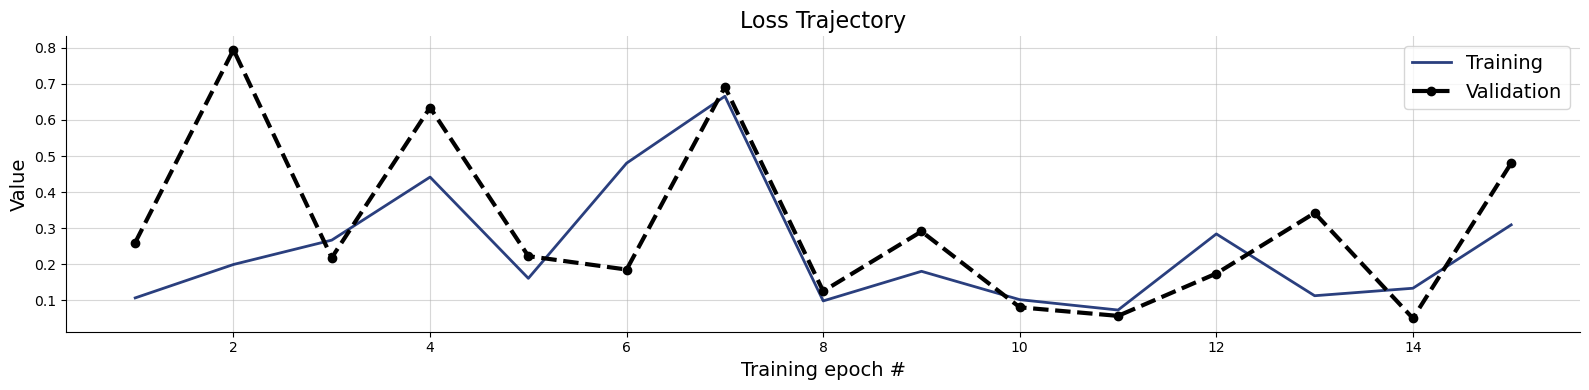

In [463]:
f = bf.diagnostics.plots.loss(history)

In [464]:
# # Set the number of posterior draws you want to get
# num_samples = 1000
num_test_samples = 500
test_idx = list(range(num_samples, num_samples + num_test_samples))

test_qsp_paths = [os.path.join(exp_dir, 'qsp_arr_' + str(i + 1) + '.npz') for i in test_idx]


In [465]:
test_observables = [np.load(path)['arr_0'] for path in test_qsp_paths]
test_observables = np.concatenate(test_observables, axis=0)
test_observables = observables_processor(test_observables)
test_params = params_processor(params_df,test_idx)
time = np.linspace(0, 1, test_observables.shape[1])
time = np.tile(time, (test_observables.shape[0], 1,1)).transpose((0,2,1))

test_sims = {"kd": test_params}


num_posterior_samples = 500
samples = workflow.sample(conditions={"sim_data": test_observables,"time": time}, num_samples=num_posterior_samples)

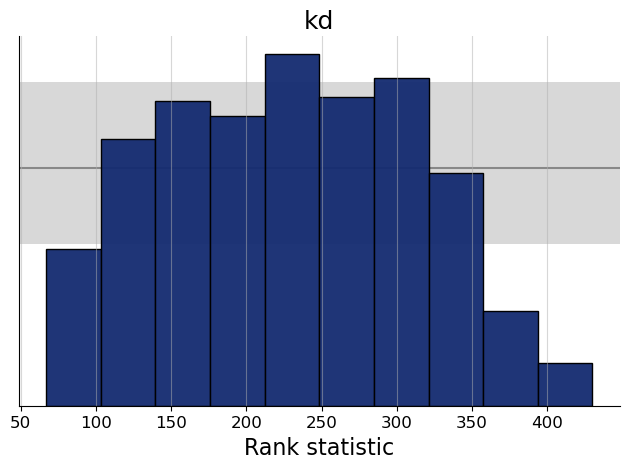

In [466]:
f = bf.diagnostics.plots.calibration_histogram(samples,test_sims)

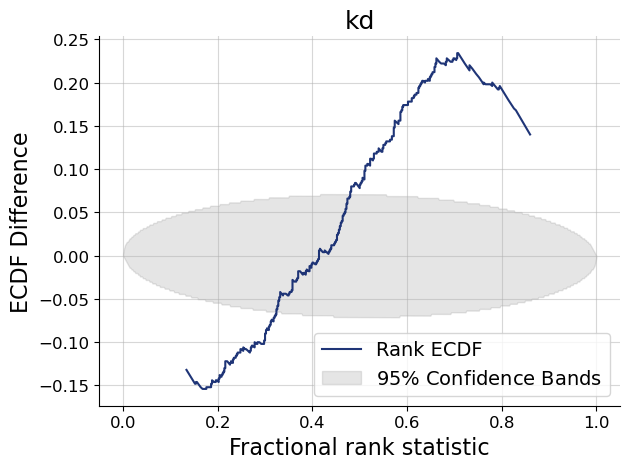

In [467]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

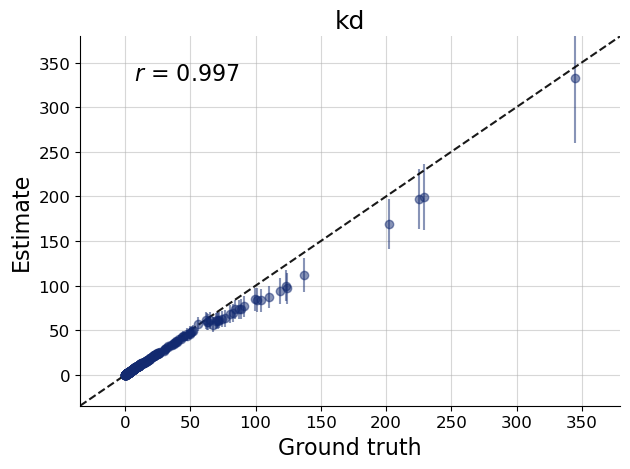

In [468]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

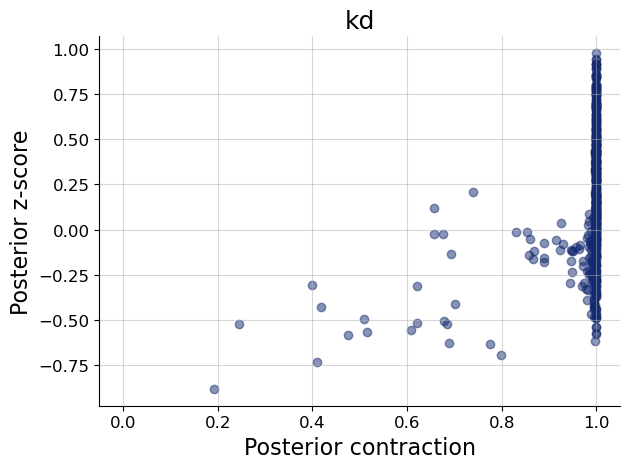

In [469]:
f = bf.diagnostics.plots.z_score_contraction(samples, test_sims)